In [36]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns
import geopandas as gpd
import cenpy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

In [2]:
NPS = gpd.read_file("C:/Users/ssmat/Documents/NPS_-_National_Register_of_Historic_Places_Locations-shp/NPS_-_National_Register_of_Historic_Places_Locations.shp")

,OBJECTID,NRIS_Refnu,PROPERTY_I,RESNAME,ResType,Address,City,County,State,Vicinity,...,SOURCE,SRC_DATE,SRC_SCALE,SRC_ACCU,SRC_COORD,ORIGINATOR,CONSTRANT,CR_ID,GEOM_ID,geometry
0,1,82004903,82004903,Walker-Broderick House,Building,541 Pine St.,Ketchikan,Ketchikan Gateway,ALASKA,None,...,National Register of Historic Places -- Nation...,1982-08-31,1:24000,+/- 12 meters,Coordinates are typically provided in UTM form...,National Register of Historic Places -- Nation...,Extant status and datum information for resour...,{5B428330-08FF-46F7-867D-35C3A84FDF0F},{D6FD98D4-BE9E-4C31-9F3D-095AFFCFEEB1},POINT (-131.64676 55.34455)
1,2,87000716,87000716,First Lutheran Church,Building,1200 Tongass Ave.,Ketchikan,Ketchikan Gateway,ALASKA,None,...,National Register of Historic Places -- Nation...,1987-05-18,1:24000,+/- 12 meters,Coordinates are typically provided in UTM form...,National Register of Historic Places -- Nation...,Extant status and datum information for resour...,{4B2E47FE-717C-4956-B460-2CA535A72A41},{CE99B08D-903E-4DEC-8247-BA95F9A6C1C9},POINT (-131.65777 55.34521)
2,3,87000645,87000645,Ketchikan Ranger House,Building,309 Gorge St.,Ketchikan,Ketchikan Gateway,ALASKA,None,...,National Register of Historic Places -- Nation...,1987-07-16,1:24000,+/- 12 meters,Coordinates are typically provided in UTM form...,National Register of Historic Places -- Nation...,Extant status and datum information for resour...,{23DF20B8-32F5-4F6C-861B-3188B30FD29F},{4413C896-7887-4201-95E1-7305CA794395},POINT (-131.65928 55.34652)
3,4,89001415,89001415,Gilmore Building,Building,326 Front St.,Ketchikan,Ketchikan Gateway,ALASKA,None,...,National Register of Historic Places -- Nation...,1989-09-27,1:24000,+/- 12 meters,Coordinates are typically provided in UTM form...,National Register of Historic Places -- Nation...,Extant status and datum information for resour...,{5BFBE8FE-BBDE-47AA-BC08-AE21BB63E16C},{59DA3A90-4DCF-4967-A6A9-6F56DD622D41},POINT (-131.64784 55.34230)
4,5,85001161,85001161,Ziegler House,Building,623 Grant St.,Ketchikan,Ketchikan Gateway,ALASKA,None,...,National Register of Historic Places -- Nation...,1985-05-30,1:24000,+/- 12 meters,Coordinates are typically provided in UTM form...,National Register of Historic Places -- Nation...,Extant status and datum information for resour...,{8D61329A-E9E4-4128-85C8-025585EEC7B8},{54B59265-DAFA-4BB3-A55A-1BB21F24B027},POINT (-131.64534 55.34447)


In [3]:
NPS = NPS[NPS['Status']!='Removed']
NPS = NPS[NPS['geometry'].isna() != True]

In [4]:
grped = NPS.groupby('State').count().reset_index()

In [163]:
alt.Chart(grped).mark_bar().encode(
    x='State:N',
    y=alt.Y('OBJECTID', title='Count'),
)

C:\Users\ssmat\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


alt.Chart(...)

In [5]:
# Add census data
acs = cenpy.remote.APIConnection("ACSDT5Y2018")

variables = ["NAME", "B01003_001E","B02008_001E","B23025_005E","B23025_001E","B29002_001E","B29002_006E","B29002_007E",
             "B29002_008E","B29003_001E","B29003_002E","B19001A_001E","B19001A_016E","B19001A_017E","B08126_001E","B08126_003E"]

In [6]:
state_data = acs.query(
    cols=variables,
    geo_unit="state:*",
)

In [7]:
for variable in variables:
    
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        state_data[variable] = state_data[variable].astype(float)

In [8]:
# Convert to the data to floats
for col in variables[1:]:
    state_data[col] = state_data[col].astype(int)

state_data.columns = ['NAME', 'POPULATION','WHITE','UNEMPLOYED','TOTAL_EMP',"edu_total","edu_1","edu_2","edu_3",
                       "pov_tot","pov_below","inc_tot","inc_high1","inc_high2","ind_tot","ind_const",'state']

In [9]:
state_data['white_per'] = state_data['WHITE'] / state_data['POPULATION'] *100

state_data['unemployed_per'] = state_data['UNEMPLOYED'] / state_data['TOTAL_EMP'] *100

state_data['edu_WithDegree_per'] = (state_data['edu_1'] + state_data['edu_2'] + state_data['edu_3']) / state_data['edu_total'] *100

state_data['BelowPoverty_per'] = state_data['pov_below'] / state_data['pov_tot'] *100

state_data['Above150_inc_per'] = (state_data['inc_high1'] + state_data['inc_high2']) / state_data['inc_tot'] *100

state_data['ind_const_per'] = state_data['ind_const']  / state_data['ind_tot'] *100

state_data = state_data[['NAME', 'POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per','ind_const_per']]

In [10]:
state_data['NAME'] = state_data['NAME'].str.upper() 

In [11]:
NPS_census = state_data.merge(
    grped,
    left_on=["NAME"],
    right_on=["State"],
)

,NAME,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,ind_const_per,State,OBJECTID,...,SOURCE,SRC_DATE,SRC_SCALE,SRC_ACCU,SRC_COORD,ORIGINATOR,CONSTRANT,CR_ID,GEOM_ID,geometry
0,MINNESOTA,5527358,85.924957,2.722489,44.187730,8.738836,15.042854,5.896057,MINNESOTA,1370,...,1370,1370,1370,1370,1370,1370,1370,1370,1370,1370
1,MISSISSIPPI,2988762,59.787765,4.681803,29.042352,17.923059,8.422468,6.559365,MISSISSIPPI,888,...,888,888,888,888,888,888,888,888,888,888
2,MISSOURI,6090062,84.580781,3.206331,33.796752,12.307478,9.723096,6.214599,MISSOURI,1672,...,1672,1672,1672,1672,1672,1672,1672,1672,1672,1672
3,MONTANA,1041732,91.525843,2.674390,36.795302,12.834789,8.609585,7.990213,MONTANA,894,...,894,894,894,894,894,894,894,894,894,894
4,NEBRASKA,1904760,89.771257,2.463994,39.501217,9.781099,10.077493,6.794072,NEBRASKA,789,...,789,789,789,789,789,789,789,789,789,789


In [12]:
NPS_census['LISTINGS_PER_POP'] = NPS_census['OBJECTID'] / NPS_census['POPULATION']

In [14]:
NPS_census = NPS_census[['NAME','OBJECTID', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per','ind_const_per']]

NPS_census.columns = ['NAME', 'NPS_count', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per','ind_const_per']

In [88]:
NPS_census['LISTINGS_PER_POP'] = NPS_census['OBJECTID'] / NPS_census['POPULATION']

NPS_census = NPS_census[['NAME','OBJECTID', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per','ind_const_per']]

NPS_census.columns = ['NAME','NPS_count', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per','ind_const_per']

In [15]:
NPS_census.head()

,NAME,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,ind_const_per
0,MINNESOTA,1370,0.000248,5527358,85.924957,2.722489,44.187730,8.738836,15.042854,5.896057
1,MISSISSIPPI,888,0.000297,2988762,59.787765,4.681803,29.042352,17.923059,8.422468,6.559365
2,MISSOURI,1672,0.000275,6090062,84.580781,3.206331,33.796752,12.307478,9.723096,6.214599
3,MONTANA,894,0.000858,1041732,91.525843,2.674390,36.795302,12.834789,8.609585,7.990213
4,NEBRASKA,789,0.000414,1904760,89.771257,2.463994,39.501217,9.781099,10.077493,6.794072


In [34]:
# Split the data 70/30
train_set, test_set = train_test_split(NPS_census, test_size=0.3, random_state=42)

# the target labels
y_train = train_set["NPS_count"].values
y_test = test_set["NPS_count"].values

# The features
feature_cols = [col for col in NPS_census.columns if col not in ["NPS_count", "NAME"]]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [45]:
train_set, test_set = train_test_split(
    NPS_census,
    test_size=0.3,
    random_state=12345,
)

# the target labels: total sites
y_train = train_set["NPS_count"].values
y_test = test_set["NPS_count"].values

In [46]:
# Extract out only the features we want to use
feature_cols = [
    "LISTINGS_PER_POP",
    "POPULATION",
    "white_per",
    "unemployed_per",
    "edu_WithDegree_per",
    "BelowPoverty_per",
    "Above150_inc_per",
    "ind_const_per",
]

train_set = train_set[feature_cols]
test_set = test_set[feature_cols]

In [35]:
# Linear model pipeline with two steps
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Fit the pipeline
# NEW: This applies all of the transformations, and then fits the model
print("Linear regression")
linear_pipe.fit(X_train, y_train)

# NEW: Print the training score
training_score = linear_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# NEW: Print the test score
test_score = linear_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Linear regression
Training Score = 0.5164495027173841
Test Score = 0.3609523731999542


In [37]:
# Make a random forest pipeline
forest_pipeline = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest_pipeline,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [ 0.33231196  0.00667779  0.16946983  0.31845385 -4.23264284  0.7570984
 -2.75384535  0.61026892 -0.3941502  -2.25225256]
Scores mean =  -0.7438610191446273
Score std dev =  1.6241880506216155


In [38]:
# Fit on the training data
forest_pipeline.fit(X_train, y_train)

# What's the test score?
forest_pipeline.score(X_test, y_test)

0.4875034055939411

In [39]:
# Extract the regressor from the pipeline
forest_model = forest_pipeline["randomforestregressor"]

In [40]:
# Create the data frame of importances
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": forest_model.feature_importances_}
).sort_values("Importance")


importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

In [41]:
importance.head()

,Feature,Importance
5,BelowPoverty_per,0.036371
2,white_per,0.039483
3,unemployed_per,0.042996
6,Above150_inc_per,0.045598
7,ind_const_per,0.061510


In [47]:
# Setup the pipeline with a standard scaler
pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(random_state=42)
)

In [48]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 10, 15, 20, 30],
    f"{model_name}__max_depth": [None, 2, 5, 7, 9, 13],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30],
 'randomforestregressor__max_depth': [None, 2, 5, 7, 9, 13]}

In [49]:
# Create the grid and use 5-fold CV
grid = GridSearchCV(pipe, param_grid, cv=5)

# Run the search
grid.fit(train_set, y_train);

In [50]:
grid.best_params_

{'randomforestregressor__max_depth': 5,
 'randomforestregressor__n_estimators': 30}

In [51]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
grid.score(test_set, y_test)

0.5612070660541342

In [52]:
# Set up a linear pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(train_set, y_train)

# Evaluate on test set
linear.score(test_set, y_test)

0.02371460649529289

In [53]:
# The best model
regressor = grid.best_estimator_["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": train_set.columns, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False)

# Plot
importance.hvplot.barh(x="Feature", y="Importance", flip_yaxis=True, height=300)

:Bars   [Feature]   (Importance)

In [54]:
importance

,Feature,Importance
1,POPULATION,0.569660
7,ind_const_per,0.106731
4,edu_WithDegree_per,0.106122
0,LISTINGS_PER_POP,0.098034
6,Above150_inc_per,0.050600
2,white_per,0.030935
5,BelowPoverty_per,0.022344
3,unemployed_per,0.015573


In [55]:
test_set.index

Int64Index([26, 39, 38, 25, 6, 28, 30, 12, 35, 44, 47, 8, 21, 19, 2, 20], dtype='int64')

In [56]:
# Extract the test data from the original dataset
# This will include the geometry data
X = NPS_census.loc[test_set.index]

In [57]:
# test data extracted from our original data frame
X.head()

,NAME,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,ind_const_per
26,WISCONSIN,1788,0.000309,5778394,87.750057,2.689803,37.567537,10.398669,10.132417,5.617952
39,GEORGIA,1327,0.000129,10297484,61.040114,3.994620,35.560154,13.303005,14.082547,6.512929
38,FLORIDA,1307,0.000063,20598139,77.628125,3.679227,37.744406,12.077290,11.271445,7.279731
25,WASHINGTON,1244,0.000171,7294336,81.120461,3.394228,42.759299,9.962031,16.277892,6.434496
6,NEW HAMPSHIRE,608,0.000453,1343622,94.967781,2.726187,42.987175,7.091749,17.000473,6.880545


In [58]:
test_set.head()

,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,ind_const_per
26,0.000309,5778394,87.750057,2.689803,37.567537,10.398669,10.132417,5.617952
39,0.000129,10297484,61.040114,3.994620,35.560154,13.303005,14.082547,6.512929
38,0.000063,20598139,77.628125,3.679227,37.744406,12.077290,11.271445,7.279731
25,0.000171,7294336,81.120461,3.394228,42.759299,9.962031,16.277892,6.434496
6,0.000453,1343622,94.967781,2.726187,42.987175,7.091749,17.000473,6.880545


In [59]:
# Predictions for log of total trip counts
predictions = grid.best_estimator_.predict(test_set)

In [ ]:
# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

AttributeError: 'Line2D' object has no property 'column'

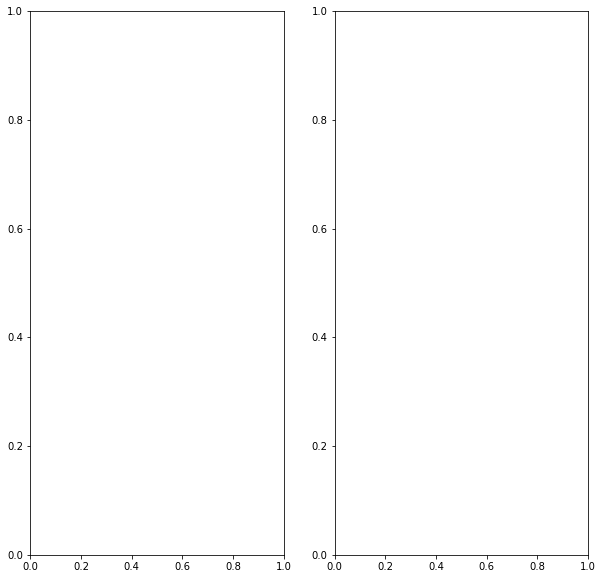

In [60]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

# Predicted values
X.plot(ax=axs[0], column='prediction')
ctx.add_basemap(ax=axs[0], crs=X.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Predicted NPS Site Counts")

# Actual values
X.plot(ax=axs[1], column='NPS_count')
ctx.add_basemap(ax=axs[1], crs=X.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Actual NPS Site Counts")


axs[0].set_axis_off()
axs[1].set_axis_off()